# Loading Data

In [295]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

raw_data = []
raw_labels = []

training_dir = os.path.join('..', 'data', '2020')

for file in [os.path.join(training_dir, _) for _ in os.listdir(training_dir) if _.endswith('.mat')]:
    basename = os.path.basename(file).split('.')[0]
    header = open(os.path.join(training_dir, f'{basename}.hea'))
    header_content = header.readlines()
    label = header_content[15].split(' ')[1].split('\n')[0]
    raw_labels.append(label)

    mat_data = scipy.io.loadmat(file)
    sequence = mat_data['val'][0]
    normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
    raw_data.append(normalised_sequence)

<ipython-input-295-25a69bef1802>:20: RuntimeWarning: overflow encountered in short_scalars
  normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))


In [296]:
conditions = {}
for i in raw_labels:
    conditions[i] = conditions.get(i, 0) + 1
print(conditions)

{'429622005': 784, '270492004': 686, '284470004': 533, '426783006': 918, '59118001': 1533, '164931005': 185, '164889003': 976, '164884008': 607, '164889003,429622005': 30, '270492004,429622005': 6, '164889003,164909002': 26, '164909002': 179, '164889003,59118001': 172, '59118001,164884008': 51, '59118001,429622005': 20, '59118001,284470004': 52, '284470004,164931005': 2, '164884008,429622005': 18, '164909002,164884008': 6, '270492004,284470004': 3, '164889003,284470004': 4, '59118001,164931005': 16, '270492004,59118001': 10, '270492004,164909002': 8, '284470004,429622005': 6, '59118001,284470004,164931005': 3, '164889003,164931005': 2, '164889003,164884008': 8, '164889003,164909002,429622005': 3, '284470004,164884008': 3, '164909002,164931005': 4, '164909002,284470004': 10, '270492004,164884008': 5, '164884008,164931005': 2, '429622005,164931005': 2, '270492004,164931005': 4}


In [297]:
from scipy.signal import butter,filtfilt
import math

def butter_lowpass_filter(data, cutoff):
    T = 10         # Sample Period
    fs = 150      # sample rate, Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2
    n = int(T * fs) # total number of samples

    normal_cutoff = cutoff / nyq
    
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def length_transfrom(x, w):
    fs = 300
    tmp = []
    for i in range(w, len(x)):
        curr = 0
        for k in range(i-w+1, i):
            curr += np.sqrt((20/fs)+np.power(x[k]-x[k-1],2))
        tmp.append(curr)
    l = [tmp[0]]*w
    
    return l+tmp

def threshold(x):
    u = np.mean(x)
    peaks = []
    fs = 300
    for i in range(len(x)):
        if (len(peaks) == 0 or i > peaks[-1]+(fs*0.18)) and x[i] > u:
            peaks.append(i)
    return peaks

def _wqrs(x):
    fs = 50
    y = butter_lowpass_filter(x, 15)
    y = length_transfrom(y, math.ceil(fs*.130))
    return threshold(y)

# Preprocessing

resample to 300 Hz

In [298]:
from scipy import interpolate
data = []
labels = []
sampling_freq = 500
down_freq = 300

for d in range(len(raw_data)):
    for i in range(0, len(raw_data[d])+10*(sampling_freq), 10*(sampling_freq)):
        if i+(10*(sampling_freq)) <= len(raw_data[d]):
            curr = raw_data[d][i:i+10*(sampling_freq)]
            y = np.zeros(3*len(curr))
            j = 0
            for i in range(0, len(curr)):
                y[j] = curr[i]
                y[j+1] = curr[i]
                y[j+2] = curr[i]
                j+=3
            
            data.append(y.reshape(-1, 5).mean(axis=1))
            labels.append(raw_labels[d])

In [299]:
import pandas as pd
from tqdm import tqdm
from ecgdetectors import Detectors
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import skew, kurtosis

def get_SQIs(x, target=0):
    fs = 300
    sSQI = skew(x, bias=False)
    kSQI = kurtosis(x, fisher=False, bias=False)
    
    def get_first_idx(x, a):
        for i in range(len(x)):
            if x[i] >= a:
                    return i

    def get_last_idx(x, a):
        for i in range(len(x)):
            if x[i] >= a:
                return i-1
                
    f, Pxx_den = welch(x, fs=300)
    u1 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 15)], x=f[get_first_idx(f, 5):get_last_idx(f, 15)])
    u2 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 40)], x=f[get_first_idx(f, 5):get_last_idx(f, 40)])
    u3 = simps(Pxx_den[get_first_idx(f, 1):get_last_idx(f, 40)], x=f[get_first_idx(f, 1):get_last_idx(f, 40)])
    u4 = simps(Pxx_den[get_first_idx(f, 0):get_last_idx(f, 40)], x=f[get_first_idx(f, 0):get_last_idx(f, 40)])

    pSQI = (u1/u2)
    basSQI = (u3/u4)
            
    detectors = Detectors(down_freq)
    
    wqrs = _wqrs(x)
    eplimited = detectors.hamilton_detector(x)
    count = 0
    j = 0
    k = 0
    while j < len(wqrs) and k < len(eplimited):
        if wqrs[j] >= eplimited[k]-0.13*fs and wqrs[j] <= eplimited[k]+0.13*fs:
            count += 1
            j+=1
            k+=1
        elif wqrs[j] > eplimited[k]:
            k+=1
        else:
            j+=1

    bSQI = (count/len(wqrs))
    rSQI = (len(wqrs)/(len(wqrs)+len(eplimited)))
    
    return [sSQI, kSQI, pSQI, basSQI, bSQI, rSQI, target]

In [300]:
test_table = pd.DataFrame(columns=['sSQI','kSQI','pSQI','basSQI','bSQI','rSQI', 'target'])
count = 0
for i in tqdm(range(len(data))):
    test_table.loc[count] = get_SQIs(data[i], labels[i])
    count += 1

  0%|          | 1/9364 [00:00<17:17,  9.03it/s]

9364 9364


100%|██████████| 9364/9364 [18:33<00:00,  8.41it/s]


In [401]:
normal_sinus = test_table.loc[test_table['target'] == '270492004,164931005']
normal_sinus.loc[:,'target'] = 0.0

sSQI_u = 0.593
kSQI_u = 12.19

sSQI_var = 4.87
kSQI_var = 218.52


normal_sinus['sSQI'] = normal_sinus['sSQI'].apply(lambda x: (x-sSQI_u) / np.sqrt(sSQI_var))
normal_sinus['kSQI'] = normal_sinus['kSQI'].apply(lambda x: (x-kSQI_u) / np.sqrt(kSQI_var))

normal_sinus.head()

/Users/Yoav2/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-401-3b3a134bcd80>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_sinus['sSQI'] = normal_sinus['sSQI'].apply(lambda x: (x-sSQI_u) / np.sqrt(sSQI_var))
<ipython-input-401-3b3a134bcd80>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,sSQI,kSQI,pSQI,basSQI,bSQI,rSQI,target
5758,1.329666,0.596300,0.396027,0.924491,1.0,0.478261,0.0
6059,0.678064,-0.183174,0.486470,0.875285,1.0,0.478261,0.0
6060,0.577332,-0.258003,0.482955,0.881656,1.0,0.478261,0.0
7756,1.329666,0.596300,0.396027,0.924491,1.0,0.478261,0.0
9060,0.678064,-0.183174,0.486470,0.875285,1.0,0.478261,0.0


In [402]:
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = load('model.joblib')
x = normal_sinus.drop(['target'], axis='columns')
y = normal_sinus.target

model.score(x, y)

1.0

426783006


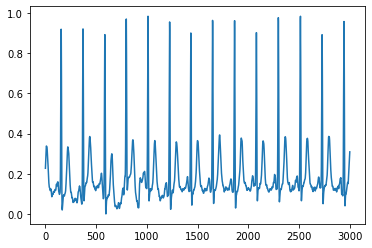

In [263]:
print(labels[5])
plt.plot(data[5])